## BeanTech Anomaly Detection Dataset

In [ ]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.btech import BTech, BTechDataset
from anomalib.pre_processing import PreProcessor
from anomalib.pre_processing.transforms import Denormalize

### Torch Dataset

In [ ]:
BTechDataset??

To create `BTechDataset` we need to import `pre_process` that applies transforms to the input image.

In [ ]:
PreProcessor??

In [3]:
pre_process = PreProcessor(image_size=256, to_tensor=True)

#### Classification Task

In [4]:
# BTechDataset Classification Train Set
btech_dataset_classification_train = BTechDataset(
    root="../../datasets/BTech",
    category="01",
    pre_process=pre_process,
    split="train",
    task="classification",
)
btech_dataset_classification_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0299.png,../../datasets/BTech/01/ground_truth/ok/0299.png,0
1,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0202.png,../../datasets/BTech/01/ground_truth/ok/0202.png,0
2,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0031.png,../../datasets/BTech/01/ground_truth/ok/0031.png,0
3,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0189.png,../../datasets/BTech/01/ground_truth/ok/0189.png,0
4,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0171.png,../../datasets/BTech/01/ground_truth/ok/0171.png,0


In [5]:
sample = btech_dataset_classification_train[0]
sample.keys(), sample["image"].shape

(dict_keys(['image']), torch.Size([3, 256, 256]))

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task

In [6]:
# BTech Classification Test Set
btech_dataset_classification_test = BTechDataset(
    root="../../datasets/BTech",
    category="01",
    pre_process=pre_process,
    split="test",
    task="classification",
)
sample = btech_dataset_classification_test[0]
sample.keys(), sample["image"].shape, sample["image_path"], sample["label"]

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([3, 256, 256]),
 '../../datasets/BTech/01/test/ko/0031.png',
 1)

where a classification test sample returns `image`, `image_path` and `label`. `image_path` is used to extract the filename when saving images.

#### Segmentation Task

It is also possible to configure the BTech dataset for the segmentation task, where the dataset object returns image and ground-truth mask.

In [7]:
# BTech Segmentation Train Set
btech_dataset_segmentation_train = BTechDataset(
    root="../../datasets/BTech",
    category="01",
    pre_process=pre_process,
    split="train",
    task="segmentation",
)
btech_dataset_segmentation_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0299.png,../../datasets/BTech/01/ground_truth/ok/0299.png,0
1,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0202.png,../../datasets/BTech/01/ground_truth/ok/0202.png,0
2,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0031.png,../../datasets/BTech/01/ground_truth/ok/0031.png,0
3,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0189.png,../../datasets/BTech/01/ground_truth/ok/0189.png,0
4,../../datasets/BTech/01,train,ok,../../datasets/BTech/01/train/ok/0171.png,../../datasets/BTech/01/ground_truth/ok/0171.png,0


The above dataframe stores all the necessary information regarding the dataset. `__getitem__` method returns the corresponding information depending on the task type or train/test split.

In [8]:
# BTech Segmentation Test Set
btech_dataset_segmentation_test = BTechDataset(
    root="../../datasets/BTech",
    category="01",
    pre_process=pre_process,
    split="test",
    task="segmentation",
)
sample = btech_dataset_segmentation_test[20]
sample.keys(), sample["image"].shape, sample["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([3, 256, 256]),
 torch.Size([256, 256]))

Let's visualize the image and the mask...

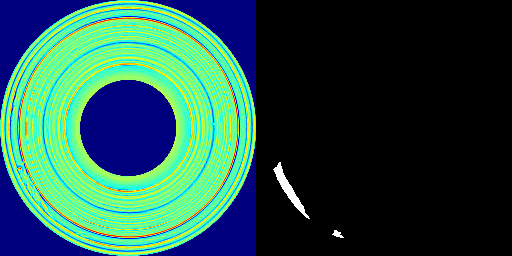

In [9]:
img = ToPILImage()(Denormalize()(sample["image"].clone()))
msk = ToPILImage()(sample["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

### DataModule

So far, we have shown the Torch Dateset implementation of BTech AD dataset. This is quite useful to get a sample. However, when we train models end-to-end fashion, we do need much more than this such as downloading the dataset, creating train/val/test/inference dataloaders. To handle all these, we have the PyTorch Lightning DataModule implementation, which is shown below

In [10]:
btech_datamodule = BTech(
    root="../../datasets/BTech",
    category="01",
    image_size=256,
    train_batch_size=32,
    test_batch_size=32,
    num_workers=8,
    task="segmentation",
)
btech_datamodule.setup()

In [11]:
# Train images
i, data = next(enumerate(btech_datamodule.train_dataloader()))
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([32, 3, 256, 256]))

In [12]:
# Test images
i, data = next(enumerate(btech_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32, 256, 256]))

As can be seen above, creating the dataloaders is pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.

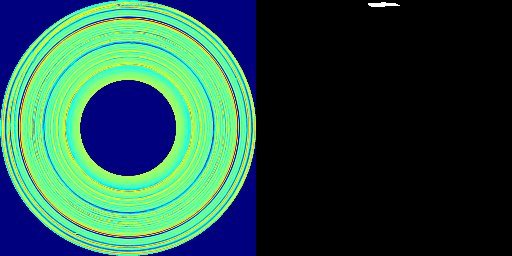

In [13]:
img = ToPILImage()(Denormalize()(data["image"][0].clone()))
msk = ToPILImage()(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))